,0,1,2,3,4,5,6,Total_POS,Total_NEG,Mean,Stddev,Variance
5 - 7,-1.809955,2.969247,2.179837,3.057851,2.100840,2.100840,3.513072,6,1,2.345748,1.967526,3.497048
5 - 9,1.244344,3.287381,2.997275,4.132231,-0.840336,-0.840336,3.839869,5,2,2.313381,1.983420,3.550458
8 - 9,2.755454,-1.516684,-2.744425,2.355808,2.906977,2.906977,-0.547731,4,3,1.457375,2.262253,4.664905
5 - 6,3.619910,0.530223,-0.272480,5.537190,0.070028,0.070028,3.594771,6,1,2.238852,2.331896,4.894752
7 - 9,3.110599,0.308960,0.800000,1.042502,-2.880658,-2.880658,0.315706,5,2,0.757383,2.404428,5.449763
4 - 9,-1.214128,-0.102564,0.710480,3.025348,1.870504,1.870504,7.711864,5,2,2.319112,2.543140,5.825366
17 - 18,-4.040921,2.872928,1.113360,-0.388500,3.728814,3.728814,1.058574,5,2,1.674785,2.552946,5.935884
12 - 13,-4.352679,3.280423,3.326810,-0.793021,0.705882,0.705882,2.723735,5,2,1.399670,2.607406,6.251314
16 - 18,0.535906,0.107527,0.503018,4.482478,0.657895,0.657895,6.547619,7,0,2.276926,2.722781,6.690253
6 - 7,-5.240175,2.426160,2.459016,-2.349256,2.029391,2.029391,-0.078864,4,3,0.919518,2.799700,7.375862


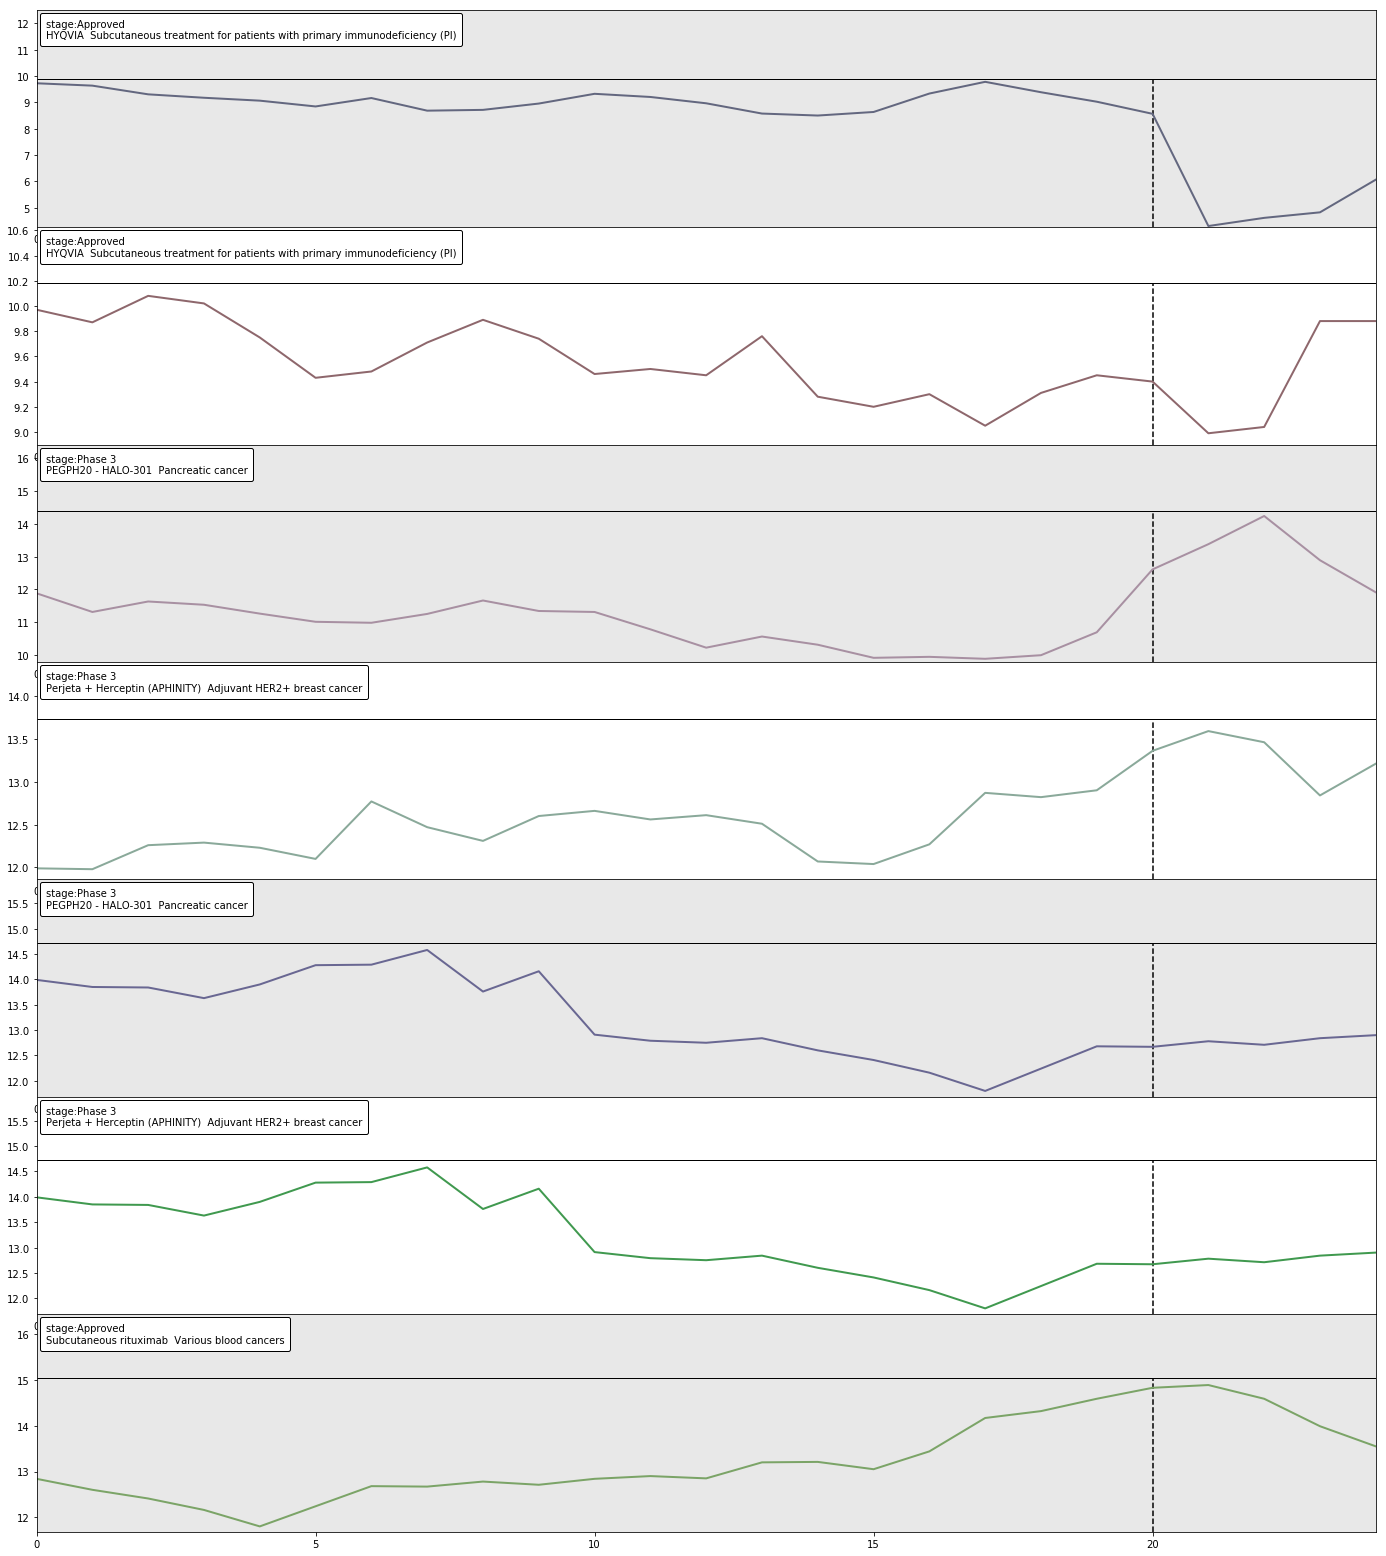

In [6]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pandas.tseries.holiday import USFederalHolidayCalendar
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

#You'll need to first set your API token here and uncomment or set externally in your OS preferably.
#%env TIINGOTOKEN inserttiingotokenhere

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create master PDUFA dataframe
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df['day_of_week'] = df['Date'].dt.day_name()
df["Original_PDUFA"] = df["Date"]
df["Date"] = df["Date"].map(lambda x : x + 0*us_bd)
df["Past"] = df["Date"] - DateOffset(weeks=3)
df["Future"] = df["Date"] + DateOffset(weeks=1)    

# Create local PDUFA dataframe for comparison
ticker="HALO"
pdufadf = df.loc[ticker]
length = len(pdufadf.index)
count = 0
tiingotoken = os.environ['TIINGOTOKEN']
oldestpdufa = df.loc[ticker]["Date"].min().date() - timedelta(days=30)
latestpdufa = df.loc[ticker]["Date"].max().date() + timedelta(days=15)
stockdf = pd.DataFrame(pd.read_json(f"https://api.tiingo.com/tiingo/daily/{ticker}/prices?startDate={oldestpdufa}&endDate={latestpdufa}&token={tiingotoken}"))

fig, axes = plt.subplots(nrows=length, ncols=1,figsize=(24,length * 4))
#set hspace and wspace to 0 for stacked "sparklines" of sorts
fig.subplots_adjust(hspace=0, wspace=0)

# Create plot data
allplots=[]
e=[]
while (count < length):
    #Initialize variable for nth PDUFA
    stage = pdufadf.iloc[count]["Stage"]
    catalyst = pdufadf.iloc[count]["Catalyst"]
    drug = pdufadf.iloc[count]["Drug"]
    
    #Annotation
    tooltip = f"stage:{stage} \n{drug}"
    at = AnchoredText(tooltip,
                      prop=dict(size=10), frameon=True,
                      loc=2, 
                      )
    at.patch.set_boxstyle("round,pad=0.2,rounding_size=0.2")
    axes[count].add_artist(at)
    axes[count].margins(0.0, 0.0)
    
    pdufa=pdufadf.iloc[count]["Date"]
    indexvalue = stockdf.index[stockdf["date"] == pdufadf.iloc[count]["Date"]][0]
    mydata = stockdf.iloc[indexvalue - 20:indexvalue + 5,].copy()
    allplots.append(mydata)
    allplots[count]["pdufa"] = allplots[count]["date"] == pdufa
    allplots[count].reset_index(inplace=True)
    axes[count].set_ylim(allplots[count]["close"].min() * .99 , (allplots[count]["close"].max()-allplots[count]["close"].min()) * 0.5 + allplots[count]["close"].max())
    axes[count].hlines(allplots[count]["close"].max() * 1.01, allplots[count].head(1).index, allplots[count].tail(1).index, linestyle="-", lw=1, color='black')
    if count % 2 == 0:
        axes[count].set_facecolor((0.91, 0.91, 0.91))  
    axes[count].vlines(allplots[count][allplots[count]["pdufa"] == True].index, allplots[count]["close"].min() * .99, allplots[count]["close"].max() * 1.01, linestyle="--", color='black')
    axes[count].plot(allplots[count].index,allplots[count]["close"],c=np.random.uniform(low=.25, high=.7, size=(3,)), lw=2, label=pdufa) 
#     axes[count].axes.get_xaxis().set_visible(False) # remove x axis
    i = 0
    total = len(allplots[count].index) - 1
    d=[]
    ecolumns=[]
    while (i < total):
        n = i + 1
        while (n < total):  # see 14 - 8 = 1.0 !!!
            rangevalue=((allplots[count].iloc[n]["close"] - allplots[count].iloc[i]["close"])/allplots[count].iloc[i]["close"] * 100)
            d.append(rangevalue)
            
            rangetest = f"{i} - {n}"
            ecolumns.append(rangetest)
            n=n + 1
        i = i + 1

    e.append(d)
    count = count + 1
#     calcdf = pd.DataFrame(e).transpose()
testdf=pd.DataFrame(e)
testdf.columns=ecolumns
calcdf=testdf.transpose()
calcdf['Total_POS'] = (calcdf.iloc[:, : len(pdufadf.index)] > 0).sum(axis=1)
calcdf['Total_NEG'] = (calcdf.iloc[:, : len(pdufadf.index)] <= 0).sum(axis=1)
calcdf['Mean'] = calcdf.mean(axis=1)
calcdf['Stddev'] = calcdf.std(axis=1)
calcdf['Variance'] = calcdf.var(axis=1)

# calcdf[(calcdf['Total_POS'] >= (length - 1)) | (calcdf['Total_NEG'] >= (length - 1))]
calcdf[(calcdf['Total_POS'] >= calcdf["Total_POS"].max() - 3)].sort_values(by=['Stddev'])
#CALCULATE ROLLING AVERAGE OR REGRESSION CURVE TO DETERMINE CONSISTENCY OF CURVE AND COMPARE TO TODAY.
# plt.show()
